In [7]:
# %tensorflow_version 2.x

In [8]:
import tensorflow
print(tensorflow.__version__)

2.1.0


In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")  # 忽略警告
import sys
sys.path.append('/home/roger/kaikeba/03_lecture/code')

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd

assert tf.__version__.startswith('2.')

from utils.config import train_data_path
from utils.data_loader import preprocess_sentence, preprocess_sentence_english, preprocess_sentence_hindi
from utils.data_loader import tokenize, max_length

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if not gpus:
    pass
try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:
    print(e)


# 重要模块：GPU自适应训练
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    

1 Physical GPUs, 1 Logical GPUs


In [11]:
# 判断是否有GPU
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2020-03-08 17:13:34,426 : WARNING : From <ipython-input-11-9909d7032bf8>:2: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [12]:
# 这里是一个印度文和英文翻译的数据集
data = pd.read_csv(train_data_path)
data.head(3)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।


In [13]:
# 统计一下有多少个英文句子，多少个印度语句子
print(data['english_sentence'].count())
print(data['hindi_sentence'].count())

127605
127607


In [14]:
data = data[data['english_sentence'].map(type) == str]  # 确保每一个句子都是字符串
data = data[data['hindi_sentence'].map(type) == str]
data = data[data['english_sentence'].map(len) > 0]  # 确保每个句子的长度均大于0
data = data[data['hindi_sentence'].map(len) > 0]

# 即实现将不符合条件的句子去掉
print(data['english_sentence'].count())
print(data['hindi_sentence'].count())

127605
127605


In [15]:
data.head(3)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।


In [16]:
# 在数据文件中增加两列，记录每一行中英语句子的长度，印度语句子的长度
data["token_size_en"] = data["english_sentence"].apply(lambda x: len(x.split(' ')))
data["token_size_hn"] = data["hindi_sentence"].apply(lambda x: len(x.split(' ')))
# 将原数据中满足下边条件的数据（包括数据和标签），复制到data里边
data = data.loc[data['token_size_hn'] < 22].copy()

In [17]:
data.head(3)

,source,english_sentence,hindi_sentence,token_size_en,token_size_hn
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर...",12,14
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...,9,11
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।,10,9


In [18]:
# 处理后留下来九万多条数据
print(data['english_sentence'].count())
print(data['hindi_sentence'].count())

90799
90799


In [19]:
# 对训练集进行处理
data['english_sentence'] = data['english_sentence'].apply(preprocess_sentence_english)
data['hindi_sentence'] = data['hindi_sentence'].apply(preprocess_sentence_hindi)

In [20]:
data.head()

,source,english_sentence,hindi_sentence,token_size_en,token_size_hn
0,ted,<start> politicians do not have permission to ...,<start> राजनीतिज्ञों के पास जो कार्य करना चाहि...,12,14
1,ted,<start> I d like to tell you about one such ch...,<start> मई आपको ऐसे ही एक बच्चे के बारे में बत...,9,11
2,indic2012,<start> This percentage is even greater than t...,<start> यह प्रतिशत भारत में हिन्दुओं प्रतिशत स...,10,9
3,ted,<start> what we really mean is that they re ba...,<start> हम ये नहीं कहना चाहते कि वो ध्यान नहीं...,12,11
4,indic2012,<start> . The ending portion of these Vedas is...,<start> इन्हीं वेदों का अंतिम भाग उपनिषद कहलात...,9,8


In [21]:
# 将data['english_sentence'].values里边的数据变为一个列表
en = data['english_sentence'].values.tolist()
hn = data['hindi_sentence'].values.tolist()

In [22]:
len(en),len(hn)

(90799, 90799)

In [23]:
en[-1],hn[-1]  # 查看两个数据的最后一个句子

('<start> They ve just won four government contracts to build off their ambulances , <end>',
 '<start> हाल ही में उन्हें सरकारी ठेका मिला है करीब सौ नई अम्बुलेन्स बनाने का , <end>')

In [24]:
def load_dataset(num_examples):
    # 读数据，这里拿了少量的样本数量
    # 这里的参数num_examples，是传入的样本个数
    # creating cleaned input, output pairs
    targ_language = data['hindi_sentence'].values.tolist()[:num_examples]
    
    inp_language = data['english_sentence'].values.tolist()[:num_examples]
    
    # 这里通过调用tokenize函数实现将选出的样本句子中的词汇转换为索引值
    input_tensor, inp_language_tokenizer = tokenize(inp_language)
    target_tensor, targ_language_tokenizer = tokenize(targ_language)

    return input_tensor, target_tensor, inp_language_tokenizer, targ_language_tokenizer

In [25]:
input_tensor, target_tensor, inp_language, targ_language = load_dataset(350)
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [26]:
print(input_tensor)

[[   1  362   55 ...    0    0    0]
 [   1   15  196 ...    0    0    0]
 [   1   13  198 ...    0    0    0]
 ...
 [   1   40   12 ...    0    0    0]
 [   1 1387  268 ...    0    0    0]
 [   1   13    9 ...    0    0    0]]


In [27]:
print(targ_language.index_word)
print(targ_language.word_index['<start>'])

{1: '<start>', 2: '<end>', 3: 'के', 4: '.', 5: 'है', 6: 'में', 7: ',', 8: 'और', 9: 'का', 10: 'की', 11: 'को', 12: 'से', 13: 'हैं', 14: 'एक', 15: 'यह', 16: 'नहीं', 17: 'कि', 18: 'है।', 19: 'पर', 20: 'भी', 21: 'लिए', 22: 'हो', 23: 'कर', 24: 'इस', 25: 'ये', 26: 'तो', 27: 'था', 28: 'हैं।', 29: 'आप', 30: 'ने', 31: 'जो', 32: 'ही', 33: 'हम', 34: 'उनके', 35: 'करने', 36: 'रही', 37: 'कोई', 38: 'बहुत', 39: 'वह', 40: 'वे', 41: 'सकता', 42: 'या', 43: 'रहा', 44: 'उस', 45: 'मैं', 46: '|', 47: 'पहले', 48: 'गया', 49: 'जा', 50: 'लेकिन', 51: 'कुछ', 52: 'हुआ', 53: 'करना', 54: 'समय', 55: 'जाती', 56: 'न', 57: 'अपने', 58: 'कारण', 59: 'थे।', 60: 'करते', 61: 'मे', 62: 'भारत', 63: 'अधिक', 64: 'हुए', 65: 'तथा', 66: 'इन', 67: 'थी', 68: 'सकते', 69: 'किसी', 70: 'होने', 71: 'साथ', 72: 'दिया', 73: 'अपनी', 74: 'राज्य', 75: 'जाता', 76: 'उन्हें', 77: 'चाहिए', 78: 'बारे', 79: 'किया', 80: 'रहे', 81: '?', 82: 'तक', 83: 'इसके', 84: 'साल', 85: 'रूप', 86: 'बार', 87: 'थे', 88: 'कहा', 89: 'जैसे', 90: 'होती', 91: 'था।', 92: 'पास',

In [28]:
# 这里展示了，转化成索引的效果，后边不够长度的部分全部补0
# 输入最大词数为35， 输出的最大词数为24，总的输入样本个数为350
print(max_length_inp,max_length_targ)
print(len(input_tensor),target_tensor[:2])

35 24
350 [[  1 409   3  92  31 212  53  77   7  39  35  17 410  16   5   4   2   0
    0   0   0   0   0   0]
 [  1 411 213 214  32  14 215   3  78   6 412 413   7   2   0   0   0   0
    0   0   0   0   0   0]]


In [29]:
# Creating training and validation sets using an 80-20 split
# 这里进行拆分训练集测试集。之前课程中都已经拆好了，不用再做了
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, 
                                                                                                target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), 
      len(target_tensor_val))

280 280 70 70


In [30]:
def convert(language, tensor):
    for t in tensor:  # 遍历tensor中的索引值
        if t != 0:
            print("%d ----> %s" % (t, language.index_word[t]))

In [31]:
print ("Input Language; index to word mapping")
convert(inp_language, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_language, target_tensor_train[0])
# 翻译的时候是两个词典，但是文本摘要的时候是可以将两个词典做成一个词典的

Input Language; index to word mapping
1 ----> <start>
29 ----> with
4 ----> the
54 ----> same
276 ----> strategy
23 ----> as
177 ----> down
80 ----> here
3 ----> .
4 ----> the
641 ----> improvement
6 ----> of
4 ----> the
34 ----> world
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
105 ----> विश्व
771 ----> सुधार
313 ----> अत्यधिक
772 ----> प्रासंगिक
186 ----> होना
77 ----> चाहिए
7 ----> ,
2 ----> <end>


In [32]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256  # 词向量的维度
units = 1024  # encoder/decoder里边的单元
vocab_inp_size = len(inp_language.word_index) + 1  # 输入字典的大小
vocab_tar_size = len(targ_language.word_index) + 1  # target字典的大小
# vocab_inp_size: 输入语言词典的大小，也就是英文词典的大小
# vocab_tar_size： 目标（标签）语言词典的大小，也就是印度语词典的大小

In [33]:
print(vocab_inp_size)

1400


## 创建一个 tf.data 数据集

In [34]:
# 之前建立数据集的常规操作: .shuffe.batch....
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, 
                                              target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [35]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 35]), TensorShape([64, 24]))

In [36]:
print(example_input_batch)

tf.Tensor(
[[  1 117   9 ...   0   0   0]
 [  1  14  37 ...   0   0   0]
 [  1  44 347 ...   0   0   0]
 ...
 [  1   8 767 ...   0   0   0]
 [  1  14 300 ...   0   0   0]
 [  1  48  22 ...   0   0   0]], shape=(64, 35), dtype=int32)


## 编写编码器 （encoder） 和解码器 （decoder） 模型

实现一个基于注意力的编码器 - 解码器模型。下图显示了注意力机制为每个输入单词分配一个权重，然后解码器将这个权重用于预测句子中的下一个单词。下图和公式是 Luong 的论文中注意力机制的一个例子。

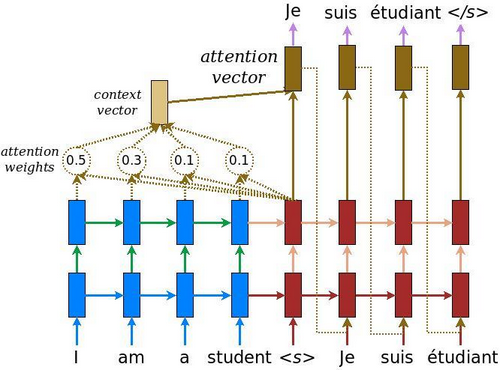


输入经过编码器模型，编码器模型为我们提供形状为 (批大小(batch_size)，最大长度(一个句子的最大长度：max_len)，隐藏层大小) 的编码器输出和形状为 (批大小，隐藏层大小) 的编码器隐藏层状态。  

下面是所实现的方程式：  
$$\alpha_{t s}=\frac{\exp \left(\operatorname{score}\left(\boldsymbol{h}_{t}, \overline{\boldsymbol{h}}_{s}\right)\right)}{\sum_{s^{\prime}=1}^{S} \exp \left(\operatorname{score}\left(\boldsymbol{h}_{t}, \overline{\boldsymbol{h}}_{s^{\prime}}\right)\right)}\ \ \ \ \ \ \ \ \ [\text { Attention weights }]$$  

$$\begin{aligned}
c_{t} &=\sum_{s} \alpha_{t s} \bar{h}_{s} & &[\text { Context vector }] \\
\boldsymbol{a}_{t} &=f\left(\boldsymbol{c}_{t}, \boldsymbol{h}_{t}\right)=\tanh \left(\boldsymbol{W}_{c}\left[\boldsymbol{c}_{t} ; \boldsymbol{h}_{t}\right]\right) & &[\text { Attention vector }]
\end{aligned}$$  

$$\operatorname{score}\left(\boldsymbol{h}_{t}, \overline{\boldsymbol{h}}_{s}\right)=\left\{\begin{array}{ll}
\boldsymbol{h}_{t}^{\top} \boldsymbol{W} \overline{\boldsymbol{h}}_{s} & [\text { Luong's multiplicative style }] \\
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{1} \boldsymbol{h}_{t}+\boldsymbol{W}_{2} \overline{\boldsymbol{h}}_{s}\right) & [\text { Bahdanau's additive style }]
\end{array}\right.$$  


这里的编码器采用 Bahdanau 注意力。在用简化形式编写之前，让我们先决定符号：

- FC = 完全连接（密集）层
- EO = 编码器输出
- H = 隐藏层状态
- X = 解码器输入  

以及伪代码：

- score = FC(tanh(FC(EO) + FC(H)))
- attention weights = softmax(score, axis = 1)。 Softmax 默认被应用于最后一个轴，但是这里我们想将它应用于 第一个轴, 因为分数 （score） 的形状是 (批大小，最大长度，隐藏层大小)。最大长度 （max_length） 是我们的输入的长度。因为我们想为每个输入分配一个权重，所以 softmax 应该用在这个轴上。
- context vector = sum(attention weights * EO, axis = 1)。选择第一个轴的原因同上。
- embedding output = 解码器输入 X 通过一个嵌入层。
- merged vector = concat(embedding output, context vector)
此合并后的向量随后被传送到 GRU


输入经过编码器模型，编码器模型为我们提供形状为 (批大小，最大长度，隐藏层大小) 的编码器输出和形状为 (批大小，隐藏层大小) 的编码器隐藏层状态。

### 测试理解交叉熵

交叉熵的理解：
这里的交叉熵的输入是这个样子的：
下边loss里边，上边是真实的标签（处理成了onehot的形式），比如这里你输入的标签字典就三个词：我爱你，那么这里的[1., 0., 0.]代表的就是“我”；[0., 1., 0.]：“爱”； [0., 0., 1.]：“你” 下边就是通过神经网络之后经过softmax之后的输出结果，通过这两个部分来计算交叉熵

In [37]:
CCe_loss = tf.keras.losses.CategoricalCrossentropy()
loss = CCe_loss([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]],
       [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])
print('Loss:', loss.numpy())

Loss: 0.09458993


下边的这种交叉熵叫做稀疏矩阵的分类交叉熵 它的输入也是一个标签，但是它输入的标签和上边的不太一样[0, 1, 2],没有经过onehot处理，这个[0, 1, 2]就是你建立的vocab里边的index，这里只需要将这个index输入进来就ok了

In [38]:
SCCe_loss = tf.keras.losses.SparseCategoricalCrossentropy()
loss = SCCe_loss(
  tf.convert_to_tensor([0, 1, 2]),
  tf.convert_to_tensor([[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]]))
print('Loss: ', loss.numpy())  # Loss: 0.3239

Loss:  0.09458992


In [39]:
help(tf.keras.losses.SparseCategoricalCrossentropy)

Help on class SparseCategoricalCrossentropy in module tensorflow.python.keras.losses:

class SparseCategoricalCrossentropy(LossFunctionWrapper)
 |  SparseCategoricalCrossentropy(from_logits=False, reduction='auto', name='sparse_categorical_crossentropy')
 |  
 |  Computes the crossentropy loss between the labels and predictions.
 |  
 |  Use this crossentropy loss function when there are two or more label classes.
 |  We expect labels to be provided as integers. If you want to provide labels
 |  using `one-hot` representation, please use `CategoricalCrossentropy` loss.
 |  There should be `# classes` floating point values per feature for `y_pred`
 |  and a single floating point value per feature for `y_true`.
 |  
 |  In the snippet below, there is a single floating point value per example for
 |  `y_true` and `# classes` floating pointing values per example for `y_pred`.
 |  The shape of `y_true` is `[batch_size]` and the shape of `y_pred` is
 |  `[batch_size, num_classes]`.
 |  
 |  

### 测试理解Loss损失函数

#### Loss函数

In [40]:
# loss调用api
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [41]:
real_label = [1, 0, 0]
print('real_label: {}'.format(real_label))
result = tf.math.equal(real_label, 1)  # 这个逻辑下是统计为1的个数
print('result: {}'.format(result))
reverse_result = tf.math.logical_not(result)  # 这里进行了一个逻辑求反，是为了统计为0的个数 这里为什么要进行反转之后再求1的个数呢？
print('reverse_result: {}'.format(reverse_result))
reverse_result_cast = tf.cast(reverse_result, dtype=tf.float32)
print('reverse_result_cast: {}'.format(reverse_result_cast))
tf.reduce_sum(reverse_result_cast, axis=-1).numpy()

real_label: [1, 0, 0]
result: [ True False False]
reverse_result: [False  True  True]
reverse_result_cast: [0. 1. 1.]


2.0

### 测试理解Encoder

In [42]:

inputs_ceshi = np.random.random([32, 10, 8]).astype(np.float32)
# 一个batch是32， 一共10个batch， 每个单词的词向量维度为8
# print(inputs)
gru_ceshi = tf.keras.layers.GRU(4)
# 这里默认不返回整个序列的输出，所以这里只返回一个batch的输出
output_ceshi = gru_ceshi(inputs_ceshi)
# print(output)
gru_ceshi = tf.keras.layers.GRU(4, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
# 这里设置返回整个序列的输出，所以就是返回了10个batch的输出
# 最终状态的输出也返回了
whole_sequence_output, final_state = gru_ceshi(inputs_ceshi)
# print(whole_sequence_output)

### 正式的Encoder-Attention-Decoder模型搭建

In [43]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # 将整数索引转化为固定大小的向量  [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
        # vocab_size: 词汇量，即词表中词的数量
        # embedding_dim: 每一个词转换为一个多少维的向量
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_initializer='glorot_uniform')
        # self.enc_units: 经过GRU层后输出的维度，也就是单元数 
        # recurrent_initializer： 初始化权重矩阵
        # return_sequences: 布尔类型. 是否返回最后的输出
        # return_state：布尔类型，是否返回输出之外的最后一个状态。
    
    def call(self, x, hidden):
        # 通过embedding获得要输入的词向量
        x = self.embedding(x)
        # print(x)  # 这里的x:一个batch是64个句子，每个句子35个词，每个词对应的词向量的维度为256
        # 将词向量输入GRU模型中
        output, state = self.gru(x, initial_state = hidden)
        
        return output, state
        # 这里的output应该就是整个序列的输出，这里的state就是最后一组返回的状态
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))
        

In [44]:
# 这一个单元格的代码，主要是为了实验上边的Decoder机制，实际上不需要这一步的实例化和输出测试,统一在下边的attention和decoder中调用即可
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 样本输入  也就是开始往模型里边输入数据
sample_hidden = encoder.initialize_hidden_state()
# print(sample_hidden[[0]])  # 可以看出，中间隐藏层权重矩阵的维度为1024
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output: (batch size, sequence length, units) {}'.format(sample_output[0].shape))
print ('Encoder Hidden state: (batch size, units) {}'.format(sample_hidden[0].shape))
print ('Encoder output: (batch size, sequence length, units) {}'.format(sample_output[0]))
print ('Encoder Hidden state: (batch size, units) {}'.format(sample_hidden[0]))
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
print(sample_hidden[:, 1])
print(sample_hidden[:, 10])
print(sample_hidden[10])

Encoder output: (batch size, sequence length, units) (35, 1024)
Encoder Hidden state: (batch size, units) (1024,)
Encoder output: (batch size, sequence length, units) [[ 1.14320926e-02  3.64579051e-03 -1.48135063e-03 ... -1.98979815e-03
  -3.97684889e-05  3.68722505e-03]
 [ 1.38189299e-02  2.60969903e-03 -4.12977859e-03 ... -3.34479799e-03
   1.23476912e-03  9.54707060e-03]
 [ 7.28885271e-03  1.12190854e-03 -5.17193321e-03 ... -4.95964382e-03
  -1.74117880e-03  1.22380396e-02]
 ...
 [-1.00526046e-02  9.78574529e-03 -4.37933253e-03 ...  7.64986407e-03
  -1.18955392e-02  1.31883575e-02]
 [-1.00528635e-02  9.78619512e-03 -4.37912252e-03 ...  7.64943659e-03
  -1.18952999e-02  1.31881479e-02]
 [-1.00530172e-02  9.78650898e-03 -4.37900005e-03 ...  7.64915906e-03
  -1.18951611e-02  1.31879942e-02]]
Encoder Hidden state: (batch size, units) [-0.01005302  0.00978651 -0.004379   ...  0.00764916 -0.01189516
  0.01318799]
Encoder output shape: (batch size, sequence length, units) (64, 35, 1024)
En

In [45]:
# 加下来就是将上边Encoder的输出：sample_output（encoder层）  sample_hidden(隐藏层的输出)输入到注意力层
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):  # 这里设置注意力层的输出单元为units
        super(BahdanauAttention, self).__init__()
        print(units)
        # 经过Dense层实现1024 -> 10
        self.W1 = tf.keras.layers.Dense(units)
        # 这里的Dense层不是第一层，所以不用设置输入的大小，只需要指定输出的维度即可，和之前一样的
        self.W2 = tf.keras.layers.Dense(units)
        self.v = tf.keras.layers.Dense(1)  # 这里最后得到的分数是一个值，所以要设置输出为1

    def call(self, query, values):
        # query：sample_hidden: hidden_state [64, 1024]  
        # values：sample_output：encoder_output [64, 35, 1024] 
        # 隐藏层的形状 == （批大小，隐藏层大小）
        # hidden_with_time_axis 的形状 == （批大小，1，隐藏层大小）
        # 由于二者之间维度不同，无法进行加法运算，这样做是为了执行加法以计算分数 1本来就可以省略，
        # 对整体没有影响
        
        hidden_with_time_axis = tf.expand_dims(query, 1)
        print(hidden_with_time_axis[0])
        print(hidden_with_time_axis)

        # 分数的形状 == （批大小，最大长度，1）  64个句子，每个句子35个词，每个词打一个分
        # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
        # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
        score = self.v(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        print ('score: (batch size, max_len, units) {}'.format(score.shape))

        # 在35个词的维度上进行softmax
        attention_weights = tf.nn.softmax(score, axis=1)
        # 35个词，每个词一个softmax输出,一般的和为1
        print ('attention_weights[1].shape: (max_len, 1) {}'.format(attention_weights[1].shape))
        print ('attention_weights[1]: (max_len, 1) {}'.format(attention_weights[1]))
        print ('attention_weights.shape: (batch, max_len, 1) {}'.format(attention_weights.shape))


        context_vector = attention_weights * values
        print ('context_vector: (batch size, max_len, units) {}'.format(context_vector.shape))
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # 将35个词的注意力合并
        print ('context_vector.shape: (batch size, max_len, units) {}'.format(context_vector.shape))

        return context_vector, attention_weights

In [46]:
# 这一个单元格的代码，主要是为了实验上边的attention机制，实际上不需要这一步的实例化和输出测试，统一在下边decoder中调用即可
attention_layer = BahdanauAttention(10)  # 这里为什么传入的是10，是为了实验一下吗？
# 这里就是调用call方法，就是将参数传给call方法
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

10
tf.Tensor(
[[-0.01005302  0.00978651 -0.004379   ...  0.00764916 -0.01189516
   0.01318799]], shape=(1, 1024), dtype=float32)
tf.Tensor(
[[[-0.01005302  0.00978651 -0.004379   ...  0.00764916 -0.01189516
    0.01318799]]

 [[-0.01005013  0.00978421 -0.0043808  ...  0.00765091 -0.0118956
    0.01318917]]

 [[-0.01005252  0.0097854  -0.00438018 ...  0.00765046 -0.01189633
    0.01318885]]

 ...

 [[-0.01005261  0.00978602 -0.00437932 ...  0.00764951 -0.01189532
    0.01318797]]

 [[-0.01004676  0.00977642 -0.00438568 ...  0.00765844 -0.01190272
    0.01318966]]

 [[-0.01004963  0.00978301 -0.00438089 ...  0.00765314 -0.01189686
    0.01318908]]], shape=(64, 1, 1024), dtype=float32)
score: (batch size, max_len, units) (64, 35, 1)
attention_weights[1].shape: (max_len, 1) (35, 1)
attention_weights[1]: (max_len, 1) [[0.02960717]
 [0.02960318]
 [0.02937504]
 [0.02918899]
 [0.02939977]
 [0.02972297]
 [0.02983296]
 [0.02944723]
 [0.02958043]
 [0.02932335]
 [0.02960354]
 [0.029502  ]
 [0.0292

In [47]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    # 这里在Decoder里边也有一个embedding，主要是因为在decoder里也有自己的输入，用翻译模型来说的话
    # 它的输入就是另一种语言（也可以理解为target）
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # 用于注意力
    self.attention = BahdanauAttention(self.dec_units)
  def call(self, x, hidden, enc_output):
    # 编码器输出（enc_output）的形状 == [batch_size, max_len, 隐藏层大小（hidden）]
    # 这里的hidden就相当于上边的query，enc_output就相当于上边的values
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x 在通过嵌入层后的形状 == [batch_size, 1, embedding_dim]
    x = self.embedding(x)

    # x 在拼接（concatenation）后的形状 == [batch_size, 1, embedding_dim+隐藏层大小]
    # 上边attention输出的context_vector的形状 == (batch_size, units) (64, 1024)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 将合并后的向量传送到GRU
    output, state = self.gru(x)

    # 输出的形状 == [batch_size * 1, 隐藏层大小]
    output = tf.reshape(output, (-1, output.shape[2]))

    # 输出的形状 == [batch_size, vocab]
    x = self.fc(output)
    return x, state, attention_weights

In [48]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
# sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)
sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab_size) {}'.format(sample_decoder_output.shape))

1024
tf.Tensor(
[[-0.01005302  0.00978651 -0.004379   ...  0.00764916 -0.01189516
   0.01318799]], shape=(1, 1024), dtype=float32)
tf.Tensor(
[[[-0.01005302  0.00978651 -0.004379   ...  0.00764916 -0.01189516
    0.01318799]]

 [[-0.01005013  0.00978421 -0.0043808  ...  0.00765091 -0.0118956
    0.01318917]]

 [[-0.01005252  0.0097854  -0.00438018 ...  0.00765046 -0.01189633
    0.01318885]]

 ...

 [[-0.01005261  0.00978602 -0.00437932 ...  0.00764951 -0.01189532
    0.01318797]]

 [[-0.01004676  0.00977642 -0.00438568 ...  0.00765844 -0.01190272
    0.01318966]]

 [[-0.01004963  0.00978301 -0.00438089 ...  0.00765314 -0.01189686
    0.01318908]]], shape=(64, 1, 1024), dtype=float32)
score: (batch size, max_len, units) (64, 35, 1)
attention_weights[1].shape: (max_len, 1) (35, 1)
attention_weights[1]: (max_len, 1) [[0.02871028]
 [0.02867554]
 [0.02868919]
 [0.02861742]
 [0.02892226]
 [0.02871381]
 [0.0288014 ]
 [0.02880396]
 [0.02898647]
 [0.02868596]
 [0.02881853]
 [0.02876858]
 [0.02

到这里整个seq2seq模型就全部建立完成，和以前的流程相同，建完模型之后进行训练和测试，在训练过程中进行计算损失，优化参数。

## 定义优化器和损失函数

具体的分析：
```
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

pad_index=vocab['<PAD>']

def loss_function(real, pred):
    # 因为在原来的句子里，处理的时候，对于长度不都的句子都填充了<PAD>
    # tf.math.equal(real, pad_index)这里是看在真实值里边有多少个和pad_index(<PAD>)相等的值
    # 加上tf.math.logical_not之后就是找的是在真实值里边不等于pad_index的值有哪些
    # 如这样的形式[1, 2, 3, 4]  [2]  ->  [False, True, False, False]
    mask = tf.math.logical_not(tf.math.equal(real, pad_index))
    # 如果矩阵里边没有填充<PAD>而是直接填充的0的话，这里的pad_index就直接写0即可
    
    # 这里计算loss的时候是将所有词的loss都计算出来
    loss_ = loss_object(real, pred)
    
    # 再往下计算的时候就只是拿没有填充的那些真实的词进行计算
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    # 这里乘以的mask就是前边求出的mask，全部是False（0）和True（1），从而实现只对真实的非填充的值做计算
    # 这里的目的就是防止填充的这些值影响权重的优化更新
    
    # 在这一部分有很大的DIY的空间，很多的地方都可以自己去尝试一下
    return tf.reduce_mean(loss_)
```

In [49]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    
    # 断logit为1和0的数量   涉及mask的时候通常都是0/1的问题，这里主要是在Report里边有的词扣掉了，是空的，要把它找出来
    # 句子长度不够的地方填充为0(<PAD>)，这里先找出这些填充的地方。
    # 然后反向找到是真实值的地方（不是句子不够长填充的地方），计算预测优化计算
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


## 检查点（基于对象保存）

In [50]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


## 训练

1. 将 *输入* 传送至 *编码器*，编码器返回 *编码器输出* 和 *编码器隐藏层状态*。
2. 将编码器输出、编码器隐藏层状态和解码器输入（即 *开始标记*：< START >）传送至解码器。
3. 解码器返回 *预测* 和 *解码器隐藏层状态*。
4. 解码器隐藏层状态被传送回模型，预测被用于计算损失。
5. 使用 *教师强制 （teacher forcing）* 决定解码器的下一个输入。
6. *教师强制* 是将 *目标词* 作为 *下一个输入* 传送至解码器的技术。
7. 最后一步是计算梯度，并将其应用于优化器和反向传播。


In [51]:
@tf.function  # tensorflow的新的功能，加一个装饰器，下边的编程方式就完全是Python的编程方式
def train_step(inp, targ, enc_hidden):
  # 这里的参数是input, target, 编码器隐藏层状态
  # 初始化Loss，一开始没有就算的时候，Loss就是0， 要进行初始化
  loss = 0

  with tf.GradientTape() as tape:

    # 这个环境下的好处是，每一步都可以拿到对应该步的梯度值，也就是求导值
    # 这里的encoder是上边实例化好的encoder，也就是定义好了，这里再传进去参数就是定义的类中的执行部分了，也就是call部分，对应的也要传进该部分的参数
    # 这里传进去的enc_hidden是初始化的编码器的隐藏层的状态
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    # 这里就实现了往Encoder层中输入数据，得到返回的数据： 
    # enc_output: (batch size, sequence length, units) (64, 35, 1024)
    # enc_hidden state: (batch size, units) (64, 1024)

    # 得到Encoder的输出之后就可以输入进Decoder进行处理了，至于Attention部分，是在Decoder中调用

    dec_hidden = enc_hidden
    # 这里Decoder（解码）层的隐藏状态的初始状态就是Encoder（编码）层输出的隐藏状态
    # Decoder的层的输入对应的是这三个部分：Encoder（编码器）输出；编码器隐藏层状态；解码器的输入（即开始的标记:<START>）编码器每个输入句子中最前边的的符号
    # 这里传入一个字典target_language: targ_lang ，调用一个查索引的函数：word_index().
    # 这里要乘以一个BATCH_SIZE，因为一次传进去的是一个batch_size
    # 这里的1就是增加维度的方向，也就是在哪一个维度上进行增加
    # 这里输入的内容就是在原来的字典中找到<start>这个输入，查到它对应的索引，找到对应的词向量，这个矩阵的长度肯定是batch_size的长度
    # 加入说词向量的维度为256，那么这里的输入的维度很可能是[64, 256],并且这64个句子的第一个词都是<start>,所以这个矩阵的每一行都是相同的。
    # 运行的时候打印一下，具体的看看 ????
    # targ_language.word_index:{'<start>': 1, '<end>': 2, 'के': 3, '.': 4, 'है': 5, 'में': 6, ',': 7, 'और': 8, 'का': 9, 'की': 10'
    # targ_language.word_index['<start>']：1  查出对应的索引
    dec_input = tf.expand_dims([targ_language.word_index['<start>']] * BATCH_SIZE, 1)
    # 增维的作用是为了进行下一步的计算，不增维会报错，具体运行的时候打印一下看看

    # 这里拿到Decoder层的输入之后，接下来就是直接循环的一个一个的进行计算，循环的长度就是你真正目标的长度，进行一个单词一个单词的预测

    # 教师强制 - 将目标词作为下一个输入
    for t in range(1, targ.shape[1]):
      # 由于：targ = dec_hidden = enc_hidden: (64, 1024),所以这里循环一个batch的大小，也就是64
      # 将编码器输出 （enc_output） 传送至解码器
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # 前边已经初始化loss了，这里直接调用loss函数，循环求出预测每个值的loss，累加loss的结果即可
      # loss函数的输入参数real和prediction，上边传进来的targ,是训练集中的真实标签，是一串词
      # targ: (64, 1024)  targ[:, t]: 每一个单元对应着一组64维的数据（64个句子中每个句子一个词，一共64个词的值），共1024个单元
      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing  缺点：泛化能力差，可以查论文，看提升的方法。
      # 这里的input在第一个循环的时候用的是<start>,第二个循环开始用的就是targ,真实的训练结果
      # 也就是说，在预测第二个的时候不是将第一个预测结果传给第二个，而是将第一个的真实值传给了第二个，因为第一个的预测结果可能是错的，会影响第二个的预测，
      # 这就是teacher forcing就是老师在教你
      # 这里为什么要增加维度，是因为每次都要将上一个预测值的真实值传进来吗
      dec_input = tf.expand_dims(targ[:, t], 1)
      # 到这里基本上就是整个训练的过程

  
  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss


In [52]:
EPOCHS = 3  # 这里设置的比较小，要不然计算速度太慢
for epoch in range(EPOCHS):
  start = time.time()  # 统计时间

  # 初始化Encoder（编码层）的隐藏层的初始状态
  enc_hidden = encoder.initialize_hidden_state()
  # 初始化总的损失。因为上边计算的是一个batch一个batch的损失，这里要进行求和
  total_loss = 0 

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    # 在前边准备的数据集中一个batch一个batch的拿，输入和标签都拿，扔到train_step函数里边
    batch_loss = train_step(inp, targ, enc_hidden)
    # 将计算出来的每一个batch的损失加到总的损失里边
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                 batch,
                                 batch_loss.numpy()))


  # 每 2 个周期（epoch），保存（检查点）一次模型
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))





Tensor("decoder/bahdanau_attention_1/strided_slice:0", shape=(1, 1024), dtype=float32)
Tensor("decoder/bahdanau_attention_1/ExpandDims:0", shape=(64, 1, 1024), dtype=float32)
score: (batch size, max_len, units) (64, 35, 1)
attention_weights[1].shape: (max_len, 1) (35, 1)
attention_weights[1]: (max_len, 1) Tensor("decoder/bahdanau_attention_1/strided_slice_2:0", shape=(35, 1), dtype=float32)
attention_weights.shape: (batch, max_len, 1) (64, 35, 1)
context_vector: (batch size, max_len, units) (64, 35, 1024)
context_vector.shape: (batch size, max_len, units) (64, 1024)
Tensor("decoder_1/bahdanau_attention_1/strided_slice:0", shape=(1, 1024), dtype=float32)
Tensor("decoder_1/bahdanau_attention_1/ExpandDims:0", shape=(64, 1, 1024), dtype=float32)
score: (batch size, max_len, units) (64, 35, 1)
attention_weights[1].shape: (max_len, 1) (35, 1)
attention_weights[1]: (max_len, 1) Tensor("decoder_1/bahdanau_attention_1/strided_slice_2:0", shape=(35, 1), dtype=float32)
attention_weights.shape: (b

Tensor("decoder_6/bahdanau_attention_1/strided_slice:0", shape=(1, 1024), dtype=float32)
Tensor("decoder_6/bahdanau_attention_1/ExpandDims:0", shape=(64, 1, 1024), dtype=float32)
score: (batch size, max_len, units) (64, 35, 1)
attention_weights[1].shape: (max_len, 1) (35, 1)
attention_weights[1]: (max_len, 1) Tensor("decoder_6/bahdanau_attention_1/strided_slice_2:0", shape=(35, 1), dtype=float32)
attention_weights.shape: (batch, max_len, 1) (64, 35, 1)
context_vector: (batch size, max_len, units) (64, 35, 1024)
context_vector.shape: (batch size, max_len, units) (64, 1024)
Tensor("decoder_7/bahdanau_attention_1/strided_slice:0", shape=(1, 1024), dtype=float32)
Tensor("decoder_7/bahdanau_attention_1/ExpandDims:0", shape=(64, 1, 1024), dtype=float32)
score: (batch size, max_len, units) (64, 35, 1)
attention_weights[1].shape: (max_len, 1) (35, 1)
attention_weights[1]: (max_len, 1) Tensor("decoder_7/bahdanau_attention_1/strided_slice_2:0", shape=(35, 1), dtype=float32)
attention_weights.sha

attention_weights[1]: (max_len, 1) Tensor("decoder_20/bahdanau_attention_1/strided_slice_2:0", shape=(35, 1), dtype=float32)
attention_weights.shape: (batch, max_len, 1) (64, 35, 1)
context_vector: (batch size, max_len, units) (64, 35, 1024)
context_vector.shape: (batch size, max_len, units) (64, 1024)
Tensor("decoder_21/bahdanau_attention_1/strided_slice:0", shape=(1, 1024), dtype=float32)
Tensor("decoder_21/bahdanau_attention_1/ExpandDims:0", shape=(64, 1, 1024), dtype=float32)
score: (batch size, max_len, units) (64, 35, 1)
attention_weights[1].shape: (max_len, 1) (35, 1)
attention_weights[1]: (max_len, 1) Tensor("decoder_21/bahdanau_attention_1/strided_slice_2:0", shape=(35, 1), dtype=float32)
attention_weights.shape: (batch, max_len, 1) (64, 35, 1)
context_vector: (batch size, max_len, units) (64, 35, 1024)
context_vector.shape: (batch size, max_len, units) (64, 1024)
Tensor("decoder_22/bahdanau_attention_1/strided_slice:0", shape=(1, 1024), dtype=float32)
Tensor("decoder_22/bahda